In [1]:
#libraries import 
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
import json
import PIL.ImageDraw as ImageDraw
import PIL.Image as Image
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img

**Organising the Train Dataset**

In [36]:
import shutil

# Base paths
image_base_path = '/data2/grp03/train'
mask_base_path = '/data2/grp03/train'
img_output_base_path = '/data2/grp03/vegetation_dataset2/train/image'
annot_output_base_path = '/data2/grp03/vegetation_dataset2/train/annotation'

# Create output directories
os.makedirs(img_output_base_path, exist_ok=True)
os.makedirs(annot_output_base_path, exist_ok=True)

# List subfolders in the image base path
subfolders = os.listdir(image_base_path)

# Loop through subfolders
for subfolder in subfolders:
    # Getting the list of image files in the current subfolder
    image_subfolder_path = os.path.join(image_base_path, subfolder)
    image_files = [f for f in os.listdir(image_subfolder_path) if f.endswith('_leftImg8bit.jpg')]

    # Looping through image files and find the corresponding mask file
    for image_file in image_files:
        # As mask and image file have initials the same, we check if a corresponding mask exists for an image
        mask_file = image_file.replace('_leftImg8bit.jpg', '_mask.png')
        mask_file_path = os.path.join(mask_base_path, subfolder, mask_file)

        # Check if the mask file exists
        if os.path.exists(mask_file_path):
            # Copying the image to the output folder
            image_source_path = os.path.join(image_subfolder_path, image_file)
            image_destination_path = os.path.join(img_output_base_path, image_file)
            shutil.copy(image_source_path, image_destination_path)

            # Copying the mask to the output folder
            mask_destination_path = os.path.join(annot_output_base_path, mask_file)
            shutil.copy(mask_file_path, mask_destination_path)

print("Dataset organization complete.")


Dataset organization complete.


**Organising the Validation Dataset**

In [37]:
import os
import shutil

# Base paths
image_base_path = '/data2/grp03/val'
mask_base_path = '/data2/grp03/val'
img_output_base_path = '/data2/grp03/vegetation_dataset2/val/image'
annot_output_base_path = '/data2/grp03/vegetation_dataset2/val/annotation'

# Create output directories
os.makedirs(img_output_base_path, exist_ok=True)
os.makedirs(annot_output_base_path, exist_ok=True)

# List subfolders in the image base path
subfolders = os.listdir(image_base_path)

# Loop through subfolders
for subfolder in subfolders:
    # Getting the list of image files in the current subfolder
    image_subfolder_path = os.path.join(image_base_path, subfolder)
    image_files = [f for f in os.listdir(image_subfolder_path) if f.endswith('_leftImg8bit.jpg')]

    # Looping through image files and find the corresponding mask file
    for image_file in image_files:
        # As mask and image file have initials the same, we check if a corresponding mask exists for an image
        mask_file = image_file.replace('_leftImg8bit.jpg', '_mask.png')
        mask_file_path = os.path.join(mask_base_path, subfolder, mask_file)

        # Check if the mask file exists
        if os.path.exists(mask_file_path):
            # Copying the image to the output folder
            image_source_path = os.path.join(image_subfolder_path, image_file)
            image_destination_path = os.path.join(img_output_base_path, image_file)
            shutil.copy(image_source_path, image_destination_path)

            # Copying the mask to the output folder
            mask_destination_path = os.path.join(annot_output_base_path, mask_file)
            shutil.copy(mask_file_path, mask_destination_path)

print("Validation Dataset organization complete.")


Validation Dataset organization complete.


In [2]:
#Parameters for the model
seed = 42 # for reproducibility
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
height = 224
width = 224
train_data_path = "/data2/grp03/vegetation_dataset2/train"
val_data_path = "/data2/grp03/vegetation_dataset2/val"

**Converting labels into masks using the polygons files**

In [27]:
#Function to create mask
def create_mask(data):
    w = data["imgWidth"]
    h = data["imgHeight"]
    image = np.zeros((w, h))
    
    region = data["objects"]
    vegetation = None 
    for i in range(len(region)):
        if region[i]["label"] == "vegetation":
            vegetation = region[i]["polygon"]
            break
    if vegetation is None:
        return np.zeros((w, h), dtype=np.uint8)        
    image = Image.new("1", (w, h))
    draw = ImageDraw.Draw(image)

    shape = tuple(map(tuple, vegetation))
    draw.polygon((shape), fill=200)

    image = np.array(image)
    image = Image.fromarray(np.uint8(plt.cm.gist_earth(image)*255))
    mask = np.array(image)

    mask = 255 - mask[:, :, 2]
    ret,mask = cv2.threshold(mask,250,255,cv2.THRESH_BINARY)
    return mask 


***Originally the images and annotations are not in same size hence we need to resize them***

In [3]:
# Get and resize train images and annotation
def get_data(path, train=True):
    ids = next(os.walk(path + "/image"))[2]
    # # print(ids)
    X = np.zeros((len(ids), height, width, 1), dtype=np.float32)
    
    # # Masks are generated only for the training data
    # if train:
    y = np.zeros((len(ids), height, width, 1), dtype=np.float32)
    # print('Getting and resizing images ... ')
   
    for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
        # Load images
        # print(n,id_)
        img = load_img(path + '/image/' + id_, color_mode = "grayscale")
        x_img = img_to_array(img)
        x_img = resize(x_img, (224, 224, 1), mode='constant', preserve_range=True)
        an_ = str(id_).split("_")[0] + "_mask.png"
        img2 = load_img(path + '/annotation/' + an_, color_mode = "grayscale")
        y_img = img_to_array(img2)
        y_img = resize(y_img, (224, 224, 1), mode='constant', preserve_range=True)
        # Save images
        X[n, ..., 0] = x_img.squeeze() / 255
        if train:
            y[n] = y_img / 255
    print('Done!')
    
    if train:
        return X, y
    else:
        return X
    
X, y = get_data(train_data_path, train=True)


/tmp/ipykernel_2251997/3273324208.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):


  0%|          | 0/4775 [00:00<?, ?it/s]

Done!


In [42]:
print(f"Dtype of X: {type(X)} and the size is {X.shape}")
print(f"Dtype of y: {type(y)} and the size is {y.shape}")

Dtype of X: <class 'numpy.ndarray'> and the size is (4775, 224, 224, 1)
Dtype of y: <class 'numpy.ndarray'> and the size is (4775, 224, 224, 1)


In [47]:
#saving the numpy array 
np.save('/data2/grp03/images_array.npy',X)
np.save('/data2/grp03/masks_array.npy',y)

In [4]:
#training and validation split 
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=seed)

/tmp/ipykernel_2251997/1984341404.py:9: UserWarning: No contour levels were found within the data range.
  ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])


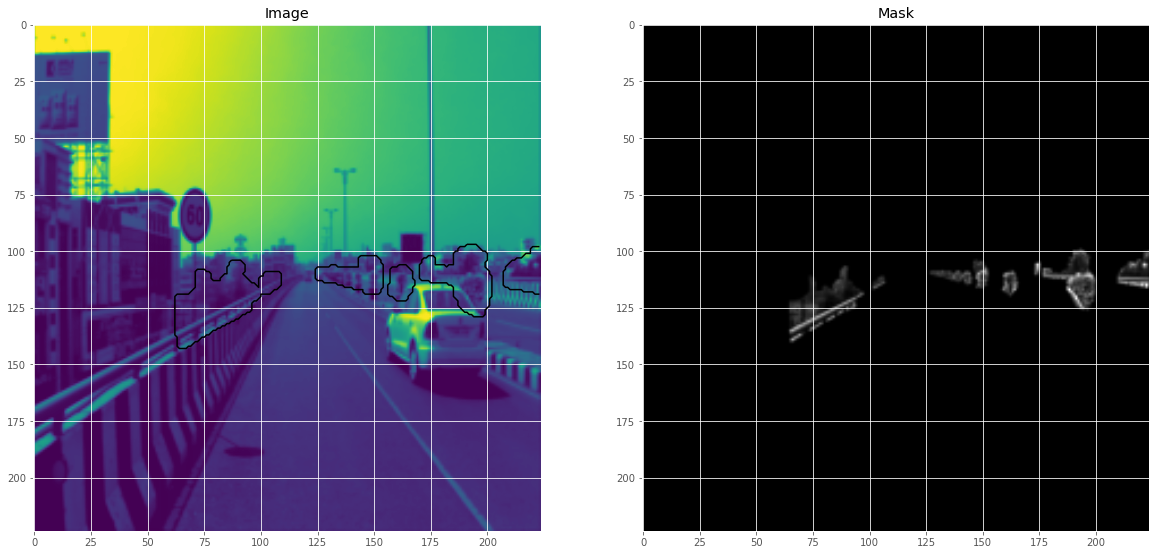

In [5]:

# Visualizing the image and corresponding  mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(X_train[ix, ..., 0], interpolation='bilinear')
if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Image')

ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('Mask');

In [48]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [49]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model
     

In [62]:
tf.keras.backend.clear_session()
input_img = Input((height, width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
# model = get_unet()
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 16  160         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [63]:
#Saving Model arch
from keras.utils import plot_model

image_path = '/data2/grp03/model_architecture_unet.png'

plot_model(model, to_file=image_path, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [64]:
#defining callbacks 
from tensorflow.keras.callbacks import TensorBoard
log_dir = "logs2"
callbacks = [
    EarlyStopping(patience=3, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model.h5', verbose=1, save_best_only=True, save_weights_only=True),
    TensorBoard(log_dir=log_dir, histogram_freq=1)
]

In [5]:
# Check GPU availability
if tf.test.gpu_device_name():
    print('GPU device found:', tf.test.gpu_device_name())
else:
    print('No GPU device found. Running on CPU.')

No GPU device found. Running on CPU.


2023-10-03 01:13:19.291398: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [68]:
results = model.fit(X_train, y_train, batch_size=32, epochs=6, callbacks=callbacks,
                    validation_data=(X_valid, y_valid))

Epoch 1/6
127/127 [==============================] - ETA: 0s - loss: 0.3353 - accuracy: 0.7677
Epoch 1: val_loss improved from inf to 0.27027, saving model to model.h5
127/127 [==============================] - 327s 3s/step - loss: 0.3353 - accuracy: 0.7677 - val_loss: 0.2703 - val_accuracy: 0.7653 - lr: 0.0010
Epoch 2/6
127/127 [==============================] - ETA: 0s - loss: 0.2136 - accuracy: 0.7701
Epoch 2: val_loss improved from 0.27027 to 0.20610, saving model to model.h5
127/127 [==============================] - 331s 3s/step - loss: 0.2136 - accuracy: 0.7701 - val_loss: 0.2061 - val_accuracy: 0.7669 - lr: 0.0010
Epoch 3/6
127/127 [==============================] - ETA: 0s - loss: 0.1575 - accuracy: 0.7702
Epoch 3: val_loss improved from 0.20610 to 0.15656, saving model to model.h5
127/127 [==============================] - 332s 3s/step - loss: 0.1575 - accuracy: 0.7702 - val_loss: 0.1566 - val_accuracy: 0.7669 - lr: 0.0010
Epoch 4/6
127/127 [==============================] - 

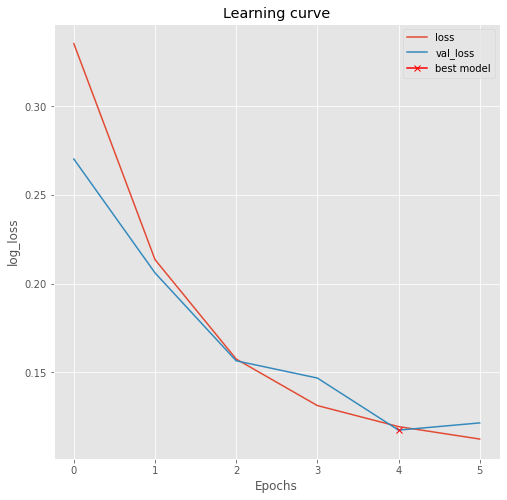

In [69]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();
plt.savefig("/data2/grp03/results/loss_chart.png")
plt.show()

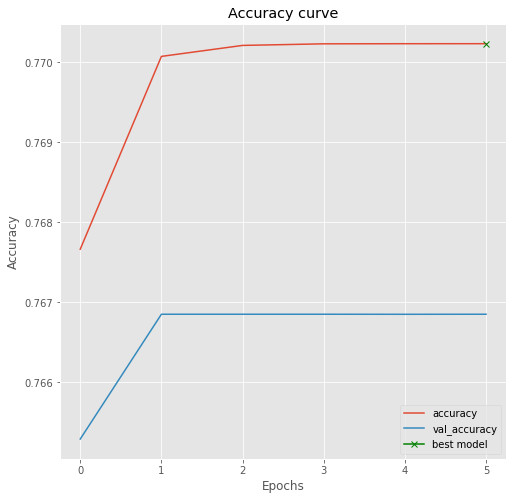

In [73]:
plt.figure(figsize=(8, 8))
plt.title("Accuracy curve")
plt.plot(results.history["accuracy"], label="accuracy")
plt.plot(results.history["val_accuracy"], label="val_accuracy")
plt.plot( np.argmax(results.history["accuracy"]), np.max(results.history["accuracy"]), marker="x", color="g", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();
plt.savefig("/data2/grp03/results/accuracy_chart.png")
plt.show()

In [ ]:
# Load best model
model.load_weights('model.h5')

In [71]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

23/23 [==============================] - 16s 695ms/step - loss: 0.1175 - accuracy: 0.7668


[0.11748731136322021, 0.7668496966362]

In [74]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.05).astype(np.uint8)
preds_val_t = (preds_val > 0.05).astype(np.uint8)
     

23/23 [==============================] - 16s 687ms/step


In [40]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Mask')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Mask Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Mask Predicted binary');

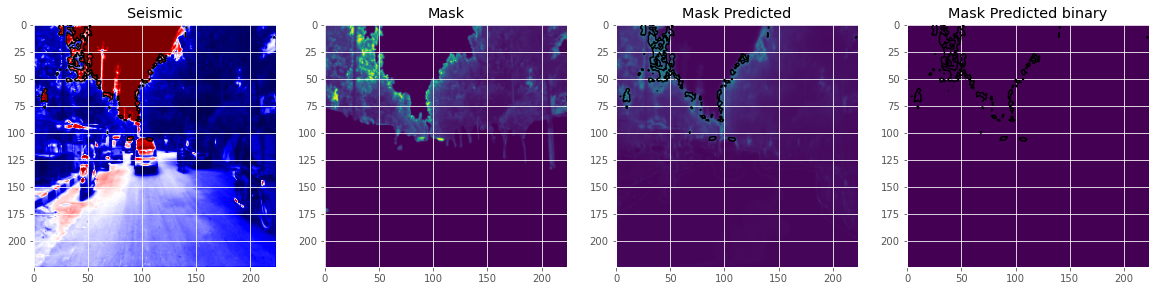

In [76]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=14)

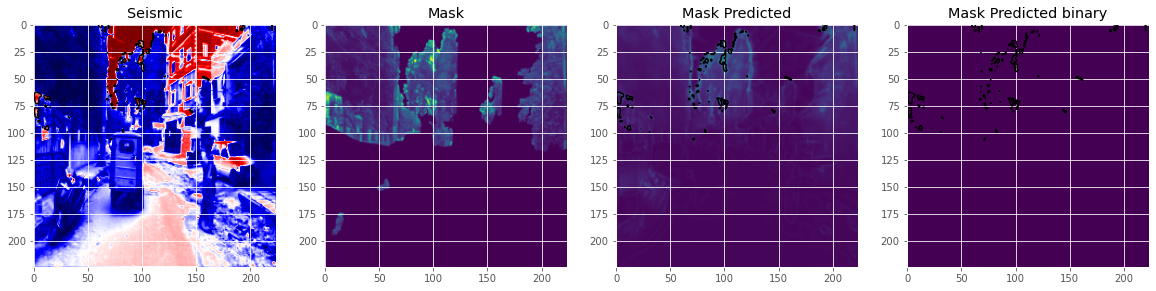

In [77]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=19)

In [78]:
import h5py
model.save('model.h5')

1/1 [==============================] - 1s 1s/step
Vegetation Percentage: 10.52295918367347%
Vegetation Quality: Poor


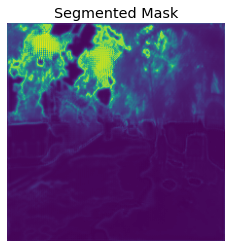

In [7]:
#Quantifying Greenery
import cv2
# Load your pre-trained semantic segmentation model
model = tf.keras.models.load_model('/data2/grp03/model.h5')

# Load the fine-tuned weights for few-shot learning
# model.load_weights('your_fine_tuned_weights_path')

def perform_segmentation(path_image):
    img = load_img(path_image, color_mode = "grayscale")
    img = img_to_array(img)
    input_img = resize(img, (224, 224, 1), mode='constant', preserve_range=True)
    input_img = input_img.squeeze() / 255
    input_img = np.expand_dims(input_img, axis=0)
    predicted_mask = model.predict(input_img)

    # Calculating the vegetation percentage in the predicted mask
    total_pixels = predicted_mask.size
    vegetation_pixels = np.sum(predicted_mask > 0.05)  # Assuming binary mask, adjust threshold as needed
    vegetation_percentage = (vegetation_pixels / total_pixels) * 100

    # Categorize vegetation quality
    if vegetation_percentage < 30:
        quality = "Poor"
    elif 30 <= vegetation_percentage <= 60:
        quality = "Moderate"
    else:
        quality = "Good"

    return predicted_mask, vegetation_percentage, quality

# performing the inference
path_image="/data2/grp03/vegetation_dataset2/train/image/0000014_leftImg8bit.jpg"
segmented_mask, vegetation_percentage, quality = perform_segmentation(path_image)

# Print the results
print(f"Vegetation Percentage: {vegetation_percentage}%")
print(f"Vegetation Quality: {quality}")

segmented_mask = np.squeeze(segmented_mask)

# Convert to a color image by duplicating the single channel to all three channels
# color_image = cv2.cvtColor(segmented_mask, cv2.COLOR_GRAY2RGB)
plt.title("Segmented Mask")
plt.imshow( segmented_mask)
plt.axis('off')  # Turn off axis labels and ticks
plt.show()



1/1 [==============================] - 0s 149ms/step
Vegetation Percentage: 0.5939094387755102%
Vegetation Quality: Poor


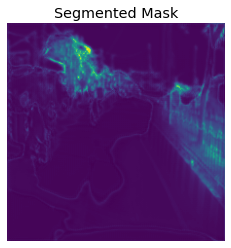

In [8]:
path_image = "/data2/grp03/vegetation_dataset2/train/image/frame106994_leftImg8bit.jpg"
segmented_mask, vegetation_percentage, quality = perform_segmentation(path_image)

# Print the results
print(f"Vegetation Percentage: {vegetation_percentage}%")
print(f"Vegetation Quality: {quality}")

segmented_mask = np.squeeze(segmented_mask)
plt.title("Segmented Mask")
plt.imshow( segmented_mask)
plt.axis('off') 
plt.show()

In [10]:
#For val images 
def get_data(path, train=True):
    ids = next(os.walk(path + "/image"))[2]
    X = np.zeros((len(ids), height, width, 1), dtype=np.float32)
    y = np.zeros((len(ids), height, width, 1), dtype=np.float32)
    for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
        img = load_img(path + '/image/' + id_, color_mode = "grayscale")
        x_img = img_to_array(img)
        x_img = resize(x_img, (224, 224, 1), mode='constant', preserve_range=True)
        an_ = str(id_).split("_")[0] + "_mask.png"
        img2 = load_img(path + '/annotation/' + an_, color_mode = "grayscale")
        y_img = img_to_array(img2)
        y_img = resize(y_img, (224, 224, 1), mode='constant', preserve_range=True)
        # Save images
        X[n, ..., 0] = x_img.squeeze() / 255
        if train:
            y[n] = y_img / 255
    print('Done!')
    
    if train:
        return X, y
    else:
        return X
    
X_val, y_val = get_data(val_data_path, train=True)


/tmp/ipykernel_2251997/3550371274.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):


  0%|          | 0/1016 [00:00<?, ?it/s]

Done!


In [11]:
#save val images 
np.save("val_images_array.npy",X_val)
np.save("val_masks_array.npy",y_val)

In [3]:
X = np.load("/data2/grp03/vegetation_dataset2/images_array.npy")
y = np.load("/data2/grp03/vegetation_dataset2/masks_array.npy")
X_val = np.load("/data2/grp03/val_images_array.npy")
y_val = np.load("/data2/grp03/val_masks_array.npy")

In [12]:
#Converting arrays to tensorflow dataset format
image_dataset = tf.data.Dataset.from_tensor_slices(X)
mask_dataset = tf.data.Dataset.from_tensor_slices(y)
val_image_dataset = tf.data.Dataset.from_tensor_slices(X_val)
val_mask_dataset = tf.data.Dataset.from_tensor_slices(y_val)

# Step 2: Create train and test datasets
batch_size = 4
auto = tf.data.AUTOTUNE
train_dataset = tf.data.Dataset.zip((image_dataset, mask_dataset))
train_dataset = (
    train_dataset
    .cache()
    .shuffle(batch_size * 10)
    .batch(batch_size)
    .prefetch(auto)
)

# Similarly, create the test dataset
test_dataset = tf.data.Dataset.zip((val_image_dataset, val_mask_dataset))
test_dataset = (
    test_dataset
    .batch(batch_size)
    .prefetch(auto)
)


In [14]:
print(train_dataset.element_spec)

(TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None))


2023-10-03 00:40:35.756088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [4775,224,224,1]
	 [[{{node Placeholder/_2}}]]


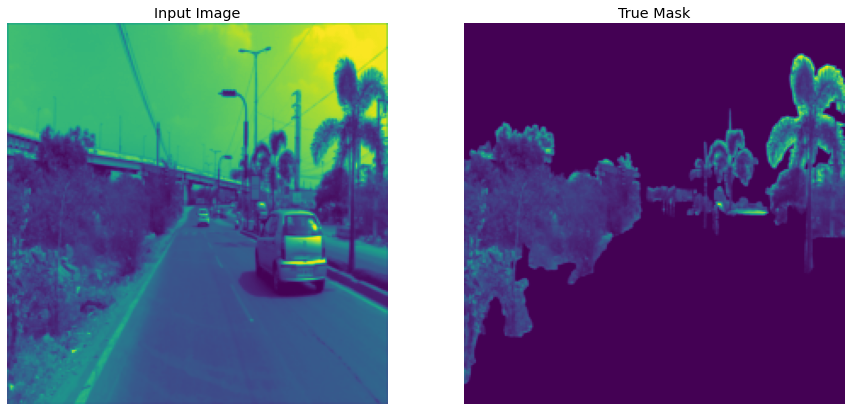

2023-10-03 00:40:36.168330: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


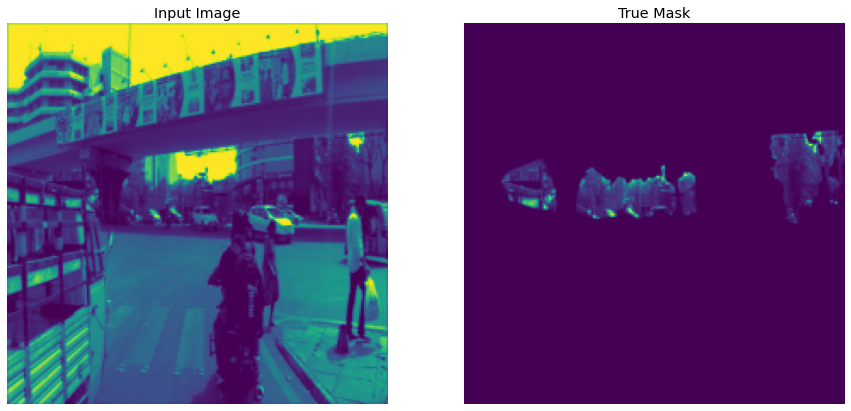

In [21]:
import tensorflow as tf
import matplotlib.pyplot as plt

def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        if len(display_list[i].shape) == 4:  
            plt.imshow(tf.keras.utils.array_to_img(display_list[i][0]))
        else:
            plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis("off")
    plt.show()

for samples in train_dataset.take(2):
    sample_image, sample_mask = samples[0], samples[1]  
    

    if len(sample_image.shape) == 4:
        display([sample_image, sample_mask])
    else:

        sample_image = tf.transpose(sample_image, (1, 2, 0))
        sample_mask = tf.expand_dims(sample_mask, -1)
        display([sample_image, sample_mask])


In [4]:
from skimage.transform import resize

# Resize images and masks to a common size
input_size = (256, 256)  # Adjust as needed
train_images = [resize(img, input_size) for img in X]
train_masks = [resize(mask, input_size, mode='constant', preserve_range=True) for mask in y]
val_images = [resize(img, input_size) for img in X_val]
val_masks = [resize(mask, input_size, mode='constant', preserve_range=True) for mask in y_val]
# test_images = [resize(img, input_size) for img in test_images]


**Using the Siamese Few Shot Learning Technique** 

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, concatenate, Flatten, Dense
import tensorflow.keras.backend as K
model = tf.keras.models.load_model('/data2/grp03/model.h5')
# Defining the Siamese network
base_model = model 
def create_siamese_model(input_shape):
    input_left = Input(shape=input_shape)
    input_right = Input(shape=input_shape)

    # Embedding function using the base_model
    embedding_left = base_model(input_left)
    embedding_right = base_model(input_right)

    # Calculating the absolute difference between embeddings
    absolute_diff = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))([embedding_left, embedding_right])

    # Fully connected layers for similarity prediction
    fc1 = Dense(128, activation='relu')(absolute_diff)
    output = Dense(1, activation='sigmoid')(fc1)

    siamese_model = Model(inputs=[input_left, input_right], outputs=output)

    return siamese_model
# Initiating the Siamese model
input_shape = X.shape[1:]  #images have shape (height, width, channels) (224,224,1)
siamese_model = create_siamese_model(input_shape)

2023-10-03 02:08:38.399781: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [9]:
from tensorflow.keras.losses import binary_crossentropy
siamese_model.compile(loss=binary_crossentropy, optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [10]:
siamese_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 224, 224, 1)  2164305     ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

In [11]:
from keras.utils import plot_model

image_path = '/data2/grp03/siamese_model_architecture_unet.png'

plot_model(siamese_model, to_file=image_path, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [12]:
# Training data (pairs of images and masks)
train_pairs = [(X[i], X[i], y[i]) for i in range(len(X))]

# Validation data (pairs of images and masks)
val_pairs = [(X_val[i], X_val[i], y_val[i]) for i in range(len(X_val))]

In [13]:
history = siamese_model.fit(
    [np.array(train_pairs)[:,0], np.array(train_pairs)[:,1]],
    np.array(train_pairs)[:,2],
    validation_data=([np.array(val_pairs)[:,0], np.array(val_pairs)[:,1]], np.array(val_pairs)[:,2]),
    batch_size=32,
    epochs=1
)

150/150 [==============================] - 812s 5s/step - loss: 0.4285 - accuracy: 0.7647 - val_loss: 0.2992 - val_accuracy: 0.7955


In [27]:
# Get and resize test images and annotation
def get_data(path, train=True):
    ids = next(os.walk(path ))[2]
    X = np.zeros((len(ids), height, width, 1), dtype=np.float32)
    for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
        img = load_img(path+id_, color_mode = "grayscale")
        x_img = img_to_array(img)
        x_img = resize(x_img, (224, 224, 1), mode='constant', preserve_range=True)
        X[n, ..., 0] = x_img.squeeze() / 255
        if train:
            y[n] = y_img / 255
    print('Done!')
    
    if train:
        return X, y
    else:
        return X
test_data_path = "/data2/grp03/test/"
X_test = get_data(test_data_path, train=False)


/tmp/ipykernel_2303079/310583239.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):


  0%|          | 0/8932 [00:00<?, ?it/s]

Done!


In [28]:
#saving the test array of images 
np.save("/data2/grp03/test_images_array.npy",X_test)

In [38]:
test_masks = []
X_test = np.load("D:/SEM7/DSE406_SDSA/ASSIGNMENT1/vegetation_dataset2/test_images_array.npy")
test_images = X_test
for test_img in test_images:
    test_pair = [test_img, test_img]
    
    # Predict the similarity score
    similarity_score = siamese_model.predict([np.array([test_pair[0]]), np.array([test_pair[1]])])[0][0]
    
    # Threshold the similarity score to create a mask
    threshold = 0.05  # Adjust based on experimentation
    predicted_mask = (similarity_score > threshold).astype(np.uint8)
    
    test_masks.append(predicted_mask)

# Save test masks as numpy arrays
np.save('test_masks.npy', np.array(test_masks))

1/1 [==============================] - 0s 140ms/step


In [2]:
# Predict on train, val and test
model = tf.keras.models.load_model('model.h5')
X_test = np.load("D:/SEM7/DSE406_SDSA/ASSIGNMENT1/vegetation_dataset2/test_images_array.npy")
preds_val = model.predict(X_test, verbose=1)

# Threshold predictions
preds_val_t = (preds_val > 0.05).astype(np.uint8)
np.save('preds_test_final.npy', preds_val_t)
     

280/280 [==============================] - 297s 1s/step


In [3]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[1].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[1].set_title('Predicted Mask (Binary)')

    plt.tight_layout()
    plt.show()

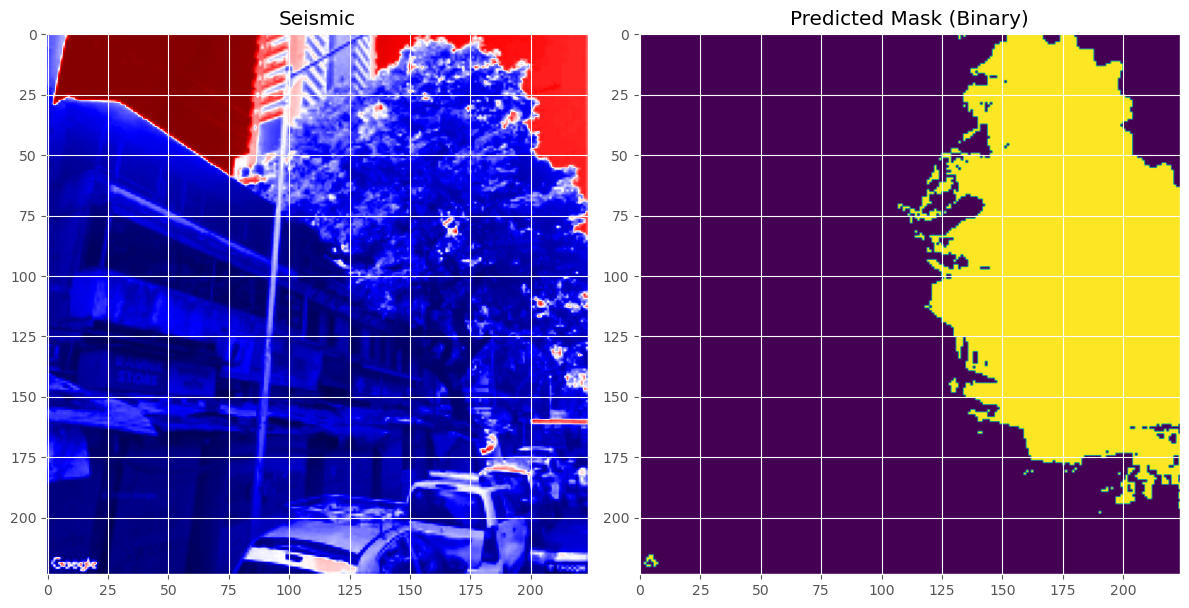

In [4]:
# Check if valid data looks all right
plot_sample(X_test, preds_val, preds_val, preds_val_t, ix=19)

1/1 [==============================] - 1s 630ms/step
Vegetation Percentage: 2.43343431122449%
Vegetation Quality: Poor


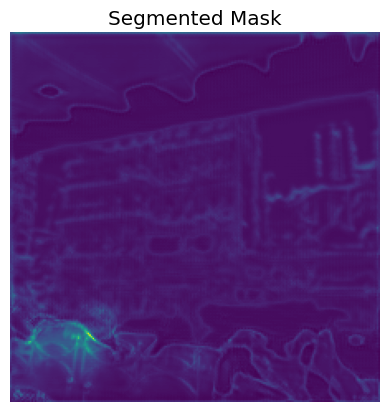

In [3]:
model = tf.keras.models.load_model('model.h5')
def perform_segmentation(path_image):
    img = load_img(path_image, color_mode = "grayscale")
    img = img_to_array(img)
    input_img = resize(img, (224, 224, 1), mode='constant', preserve_range=True)
    input_img = input_img.squeeze() / 255
    input_img = np.expand_dims(input_img, axis=0)
    predicted_mask = model.predict(input_img)

    
    total_pixels = predicted_mask.size
    vegetation_pixels = np.sum(predicted_mask > 0.05)  
    vegetation_percentage = (vegetation_pixels / total_pixels) * 100

    # Categorize vegetation quality
    if vegetation_percentage < 30:
        quality = "Poor"
    elif 30 <= vegetation_percentage <= 60:
        quality = "Moderate"
    else:
        quality = "Good"

    return predicted_mask, vegetation_percentage, quality


path_image="D:/SEM7/DSE406_SDSA/ASSIGNMENT1/test/22850584_585_100.0_60.jpg"
segmented_mask, vegetation_percentage, quality = perform_segmentation(path_image)

# Print the results
print(f"Vegetation Percentage: {vegetation_percentage}%")
print(f"Vegetation Quality: {quality}")

segmented_mask = np.squeeze(segmented_mask)

# Convert to a color image by duplicating the single channel to all three channels
# color_image = cv2.cvtColor(segmented_mask, cv2.COLOR_GRAY2RGB)
# plt.subplots(1,2,figsize=(12,8))
plt.title("Segmented Mask")
plt.imshow( segmented_mask)
plt.axis('off')  # Turn off axis labels and ticks
plt.show()



1/1 [==============================] - 0s 66ms/step
Vegetation Percentage: 52.18231823979592%
Vegetation Quality: Moderate


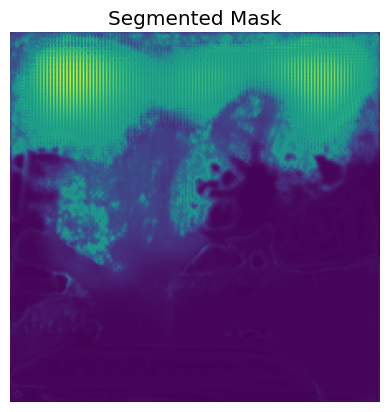

In [4]:
path_image = "D:/SEM7/DSE406_SDSA/ASSIGNMENT1/test/22850586_587_0.0_180.jpg"
segmented_mask, vegetation_percentage, quality = perform_segmentation(path_image)

# Print the results
print(f"Vegetation Percentage: {vegetation_percentage}%")
print(f"Vegetation Quality: {quality}")

segmented_mask = np.squeeze(segmented_mask)

# Convert to a color image by duplicating the single channel to all three channels
# color_image = cv2.cvtColor(segmented_mask, cv2.COLOR_GRAY2RGB)
# plt.subplots(1,2,figsize=(12,8))
plt.title("Segmented Mask")
plt.imshow( segmented_mask)
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

Vegetation Percentage: 52.18231823979592%
Vegetation Quality: Moderate


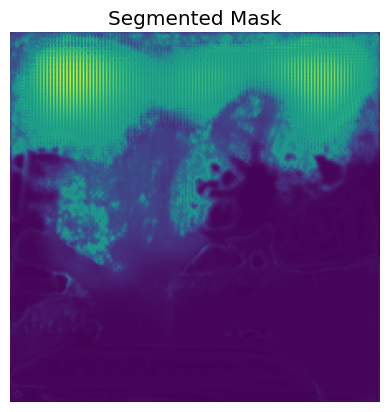

In [5]:
path_image = "D:/SEM7/DSE406_SDSA/ASSIGNMENT1/test/1146453803_34841_44.82326253848608_300.jpg"
print(f"Vegetation Percentage: {vegetation_percentage}%")
print(f"Vegetation Quality: {quality}")

segmented_mask = np.squeeze(segmented_mask)

# Convert to a color image by duplicating the single channel to all three channels
# color_image = cv2.cvtColor(segmented_mask, cv2.COLOR_GRAY2RGB)
# plt.subplots(1,2,figsize=(12,8))
plt.title("Segmented Mask")
plt.imshow( segmented_mask)
plt.axis('off')  # Turn off axis labels and ticks
plt.show()